# Raster Analysis

This is additional supplementary to the original report. I have saved this code here because of the large amount of RAM required to run this. Please try not to run this as, by experience, it would take more than 2 hours to run.

In [1]:
import re, functools
from glob import glob
import rasterio as rs
import rasterstats as rstats
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
countries_geojson = gp.read_file("https://datahub.io/core/geo-ne-admin1/r/admin1.geojson")
countries_geojson.to_file("data/country/world_locations.json", driver='GeoJSON')
countries_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


In [2]:
countries_geojson = gp.read_file("data/country/world_locations.json")
countries_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


<AxesSubplot:>

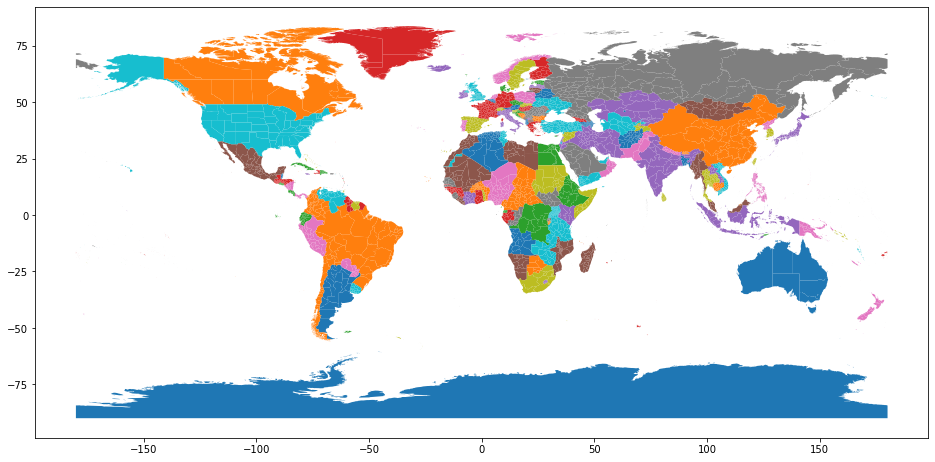

In [4]:
countries_geojson.plot("country", figsize=(16, 8))

In [7]:
def retrieveGeoStats(raster_file, nodata=255):
    year = re.search(r"\d+", raster_file).group()
    print(f"Processing {year}...", end="\t")
    rf = rs.open(raster_file,"r")
    values = pd.DataFrame(rstats.zonal_stats(countries_geojson, rf.read(1), affine=rf.transform, stats=["count", "mean", "min", "max", 'median', 'std', "majority"], geojson_out=True, nodata=nodata))
    del rf
    #return countries_geojson.merge()
    df = pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["id", "type", "properties", "bbox", "ISO3166-1-Alpha-3", "geometry"]).rename(columns={"majority": "mode"}).set_index(["country", "name"]).rename(columns=lambda q: (year, q)).T.reset_index().fillna(0)
    df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
    return df.drop(columns=["index"]).set_index(["Year", "Quantity"])
    #return pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["geometry", "properties", "ISO3166-1-Alpha-3"]).rename(columns={"majority":"mode"}).set_index(["country", "bbox"]).drop(columns=["id", "type"]).rename(columns=lambda name: f"{name}LightPollution{year}").rename(columns={f"countLightPollution{year}":f"recordCount{year}"}).reset_index()

nightLight2013 = retrieveGeoStats("data/nightLight/DN_NTL_2013_simVIIRS.tif")
nightLight2013

Processing 2013...	

C:\Users\Prannaya\.conda\envs\analytics\lib\site-packages\IPython\core\interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


ValueError: cannot handle a non-unique multi-index!

In [10]:
nightLight2013.rename(columns=lambda tup: tup[-1]).to_csv("data/nightLight/nightLight2013.csv")
nightLight2013.rename(columns=lambda tup: tup[-1])

min   max       mean  count        std  \
country     name                                                         
Aruba       Aruba               7.0  57.0  28.666667    201  16.178831   
Afghanistan Badghis             0.0  32.0   0.236040  29334   1.336606   
            Hirat               0.0  56.0   0.741159  78071   2.932197   
            Bamyan              0.0   8.0   0.180535  25153   1.039803   
            Balkh               0.0  61.0   2.011429  23275   5.675208   
...                             ...   ...        ...    ...        ...   
Zimbabwe    Manicaland          0.0  46.0   1.915220  42982   3.263857   
            Matabeleland South  0.0  52.0   0.677659  68170   2.175918   
            Bulawayo            0.0  55.0  21.061511    569  15.322821   
            Masvingo            0.0  26.0   0.701861  69850   2.066331   
            Mashonaland West    0.0  49.0   4.252489  70118   3.467990   

                                median  mode  
country     name                              
Aruba       Aruba                 28.0   7.0  
Afghanistan Badghis                0.0   0.0  
            Hirat                  0.0   0.0  
            Bamyan                 0.0   0.0  
            Balkh                  0.0   0.0  
...                                ...   ...  
Zimbabwe    Manicaland             0.0   0.0  
            Matabeleland South     0.0   0.0  
            Bulawayo              14.0   7.0  
            Masvingo               0.0   0.0  
            Mashonaland West       6.0   6.0  

[4647 rows x 7 columns]

In [6]:
nightLight2013.dtypes

(2013, min)       float64
(2013, max)       float64
(2013, mean)      float64
(2013, count)       int64
(2013, std)       float64
(2013, median)    float64
(2013, mode)      float64
dtype: object

In [5]:
nightLight = functools.reduce(pd.DataFrame.join, map(retrieveGeoStats, glob("data/nightLight/Harmonized*.tif")))
nightLight

Processing 1992...	Processing 1993...	Processing 1994...	Processing 1995...	Processing 1996...	Processing 1997...	Processing 1998...	Processing 1999...	Processing 2000...	Processing 2001...	Processing 2002...	Processing 2003...	Processing 2004...	Processing 2005...	Processing 2006...	

MemoryError: Unable to allocate 117. MiB for an array with shape (1, 15336531) and data type int64

In [2]:
df = nightLight.T.reset_index().fillna(0)
df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
df = df.drop(columns=["index"]).set_index(["Year", "Quantity"])
df.to_csv("data/nightLight/nightLight.csv")
del df


NameError: name 'nightLight' is not defined

In [3]:
nightLightCSV = pd.read_csv("data/nightLight/nightLight.csv")
nightLightCSV

,Year,Quantity,Aruba,Afghanistan,Angola,Anguilla,Albania,Aland,Andorra,United Arab Emirates,...,U.S. Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Akrotiri Sovereign Base Area,Samoa,Yemen,South Africa,Zambia,Zimbabwe
0,1992,min,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,1992,max,63.000000,59.000000,6.300000e+01,21.000000,39.000000,53.000000,63.000000,63.000000,...,63.000000,63.000000,33.000000,5.000000,39.000000,25.000000,63.000000,6.300000e+01,63.000000,63.000000
2,1992,mean,30.731343,0.027943,3.853196e-02,9.650000,0.264269,2.225571,15.614627,5.759838,...,32.455814,0.428158,0.148032,0.614458,14.912409,0.213944,0.290173,1.011056e+00,0.086135,0.237517
3,1992,count,201.000000,901332.000000,1.491515e+06,100.000000,43766.000000,2190.000000,711.000000,90768.000000,...,430.000000,402417.000000,14990.000000,166.000000,137.000000,3342.000000,550751.000000,1.628866e+06,904610.000000,481200.000000
4,1992,std,18.759739,0.777678,9.276639e-01,4.665565,1.677334,7.450677,14.907233,12.631190,...,21.645917,2.280519,1.422269,1.511652,6.933968,1.448707,2.234735,5.345446e+00,1.452076,2.465630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2018,mean,37.089552,2.047282,1.631923e+00,15.900000,8.770347,4.557534,24.846695,17.602481,...,25.711628,8.588959,1.618412,5.855422,34.408759,3.311191,1.301654,4.085443e+00,3.077475,2.009717
185,2018,count,201.000000,901332.000000,1.491515e+06,100.000000,43766.000000,2190.000000,711.000000,90768.000000,...,430.000000,402417.000000,14990.000000,166.000000,137.000000,3342.000000,550751.000000,1.628866e+06,904610.000000,481200.000000
186,2018,std,16.243543,3.555359,3.834231e+00,7.139328,7.885158,10.894895,17.029646,19.567906,...,17.255551,10.506223,6.371589,1.767392,14.801142,3.743191,4.136651,7.545370e+00,4.123423,3.633314
187,2018,median,40.000000,0.000000,0.000000e+00,14.000000,7.000000,0.000000,19.000000,8.000000,...,20.500000,7.000000,0.000000,6.000000,34.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [4]:
data = nightLightCSV.set_index(["Quantity", "Year"]).loc["mean"].T.rename(columns="nightLight{}".format).reset_index()
data

Year,index,nightLight1992,nightLight1993,nightLight1994,nightLight1995,nightLight1996,nightLight1997,nightLight1998,nightLight1999,nightLight2000,...,nightLight2009,nightLight2010,nightLight2011,nightLight2012,nightLight2013,nightLight2014,nightLight2015,nightLight2016,nightLight2017,nightLight2018
0,Aruba,30.731343,31.004975,29.975124,33.283582,31.786070,35.223881,40.631841,38.577114,39.616915,...,35.584158,31.851485,36.316832,37.621891,36.671642,29.815920,30.288557,31.820896,36.741294,37.089552
1,Afghanistan,0.027943,0.020531,0.018001,0.029921,0.029857,0.028192,0.033865,0.029054,0.036122,...,0.129832,0.161546,0.177007,0.212513,0.194248,0.575179,0.493476,0.452266,7.020362,2.047282
2,Angola,0.038532,0.031502,0.030800,0.032261,0.038715,0.040266,0.047467,0.050220,0.048832,...,0.127417,0.148146,0.163070,0.190780,0.191503,2.096078,2.173108,2.220793,3.066577,1.631923
3,Anguilla,9.650000,9.320000,11.300000,14.880000,14.910000,16.880000,18.670000,18.440000,18.080000,...,23.656566,25.151515,22.929293,26.730000,26.500000,19.470000,20.340000,20.260000,18.640000,15.900000
4,Albania,0.264269,0.694603,0.815907,1.456427,1.275168,0.962711,1.325412,1.845519,1.907874,...,2.944766,2.830412,3.321625,3.442353,3.730476,7.328428,6.791322,6.172371,9.455605,8.770347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Samoa,0.213944,0.461101,0.400658,0.496709,0.664572,0.686116,1.036804,0.736086,1.190006,...,0.686902,1.008074,0.975179,0.814183,0.600239,1.036505,0.950928,0.943148,2.749551,3.311191
251,Yemen,0.290173,0.362772,0.333174,0.364695,0.332782,0.338080,0.416544,0.479552,0.533130,...,0.851812,1.023286,0.936954,0.895347,0.916243,1.366868,1.015312,0.723512,1.267724,1.301654
252,South Africa,1.011056,1.022081,1.033102,1.189687,1.292710,1.263283,1.350791,1.428955,1.462017,...,1.594615,1.618164,1.674602,1.841812,1.721415,3.561837,3.320646,3.273140,4.210063,4.085443
253,Zambia,0.086135,0.084536,0.088071,0.103435,0.105910,0.105935,0.104625,0.101848,0.115517,...,0.139525,0.154662,0.159207,0.182403,0.181692,2.640483,2.793083,2.747586,3.963987,3.077475


In [5]:
corr = data.drop(columns="index").corr()
corr

Year,nightLight1992,nightLight1993,nightLight1994,nightLight1995,nightLight1996,nightLight1997,nightLight1998,nightLight1999,nightLight2000,nightLight2001,...,nightLight2009,nightLight2010,nightLight2011,nightLight2012,nightLight2013,nightLight2014,nightLight2015,nightLight2016,nightLight2017,nightLight2018
Year,,,,,,,,,,,,,,,,,,,,,
nightLight1992,1.000000,0.994915,0.994016,0.990455,0.990390,0.988371,0.982966,0.982296,0.981646,0.978163,...,0.966794,0.960197,0.965362,0.963383,0.966044,0.942245,0.940497,0.938658,0.919293,0.916352
nightLight1993,0.994915,1.000000,0.998116,0.994003,0.994029,0.991641,0.987036,0.984173,0.982641,0.980124,...,0.970107,0.959971,0.965690,0.963628,0.964956,0.935992,0.934081,0.931996,0.911766,0.909007
nightLight1994,0.994016,0.998116,1.000000,0.994995,0.994146,0.992691,0.987186,0.984931,0.984199,0.980902,...,0.970185,0.961187,0.965099,0.965132,0.966157,0.935905,0.934017,0.931890,0.910885,0.908368
nightLight1995,0.990455,0.994003,0.994995,1.000000,0.997149,0.994454,0.992225,0.991139,0.990515,0.987434,...,0.981835,0.976722,0.975872,0.976969,0.976861,0.944057,0.941928,0.940500,0.921267,0.919713
nightLight1996,0.990390,0.994029,0.994146,0.997149,1.000000,0.997158,0.994179,0.993404,0.992161,0.990230,...,0.983663,0.978086,0.979510,0.978145,0.979596,0.947903,0.945747,0.944356,0.925154,0.923568
nightLight1997,0.988371,0.991641,0.992691,0.994454,0.997158,1.000000,0.994806,0.993963,0.992070,0.991500,...,0.984326,0.975905,0.979487,0.976724,0.979496,0.946120,0.943960,0.942684,0.923829,0.921013
nightLight1998,0.982966,0.987036,0.987186,0.992225,0.994179,0.994806,1.000000,0.998021,0.996387,0.996522,...,0.985858,0.980288,0.980304,0.982865,0.982076,0.938911,0.936831,0.936420,0.919033,0.916065
nightLight1999,0.982296,0.984173,0.984931,0.991139,0.993404,0.993963,0.998021,1.000000,0.997993,0.997205,...,0.986871,0.982687,0.981860,0.984416,0.984673,0.943633,0.941501,0.941056,0.923921,0.921261
nightLight2000,0.981646,0.982641,0.984199,0.990515,0.992161,0.992070,0.996387,0.997993,1.000000,0.997568,...,0.987302,0.984175,0.981460,0.986691,0.986016,0.947024,0.944637,0.944185,0.927749,0.924811


<AxesSubplot:xlabel='Year', ylabel='Year'>

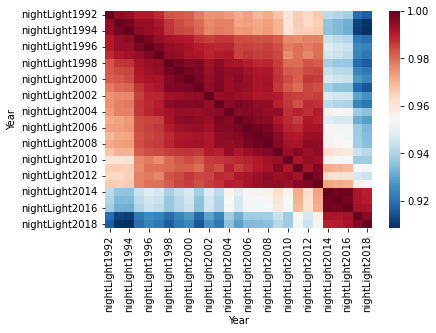

In [6]:
sns.heatmap(corr, cmap="RdBu_r")

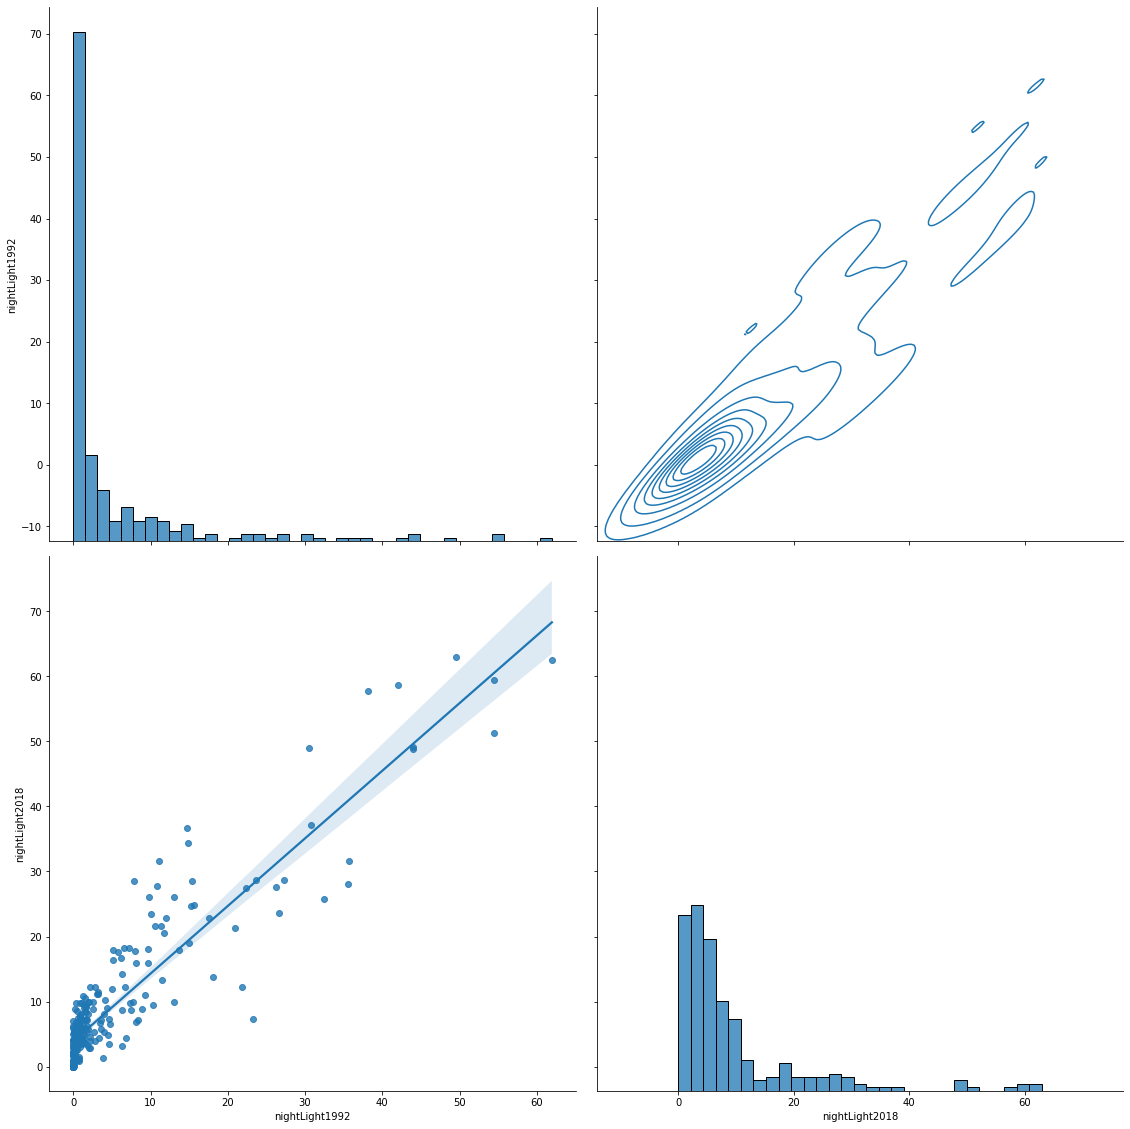

In [7]:
sns.PairGrid(data[["nightLight1992", "nightLight2018"]], height=8).map_diag(sns.histplot).map_lower(sns.regplot).map_upper(sns.kdeplot)

<AxesSubplot:xlabel='Year', ylabel='Value'>

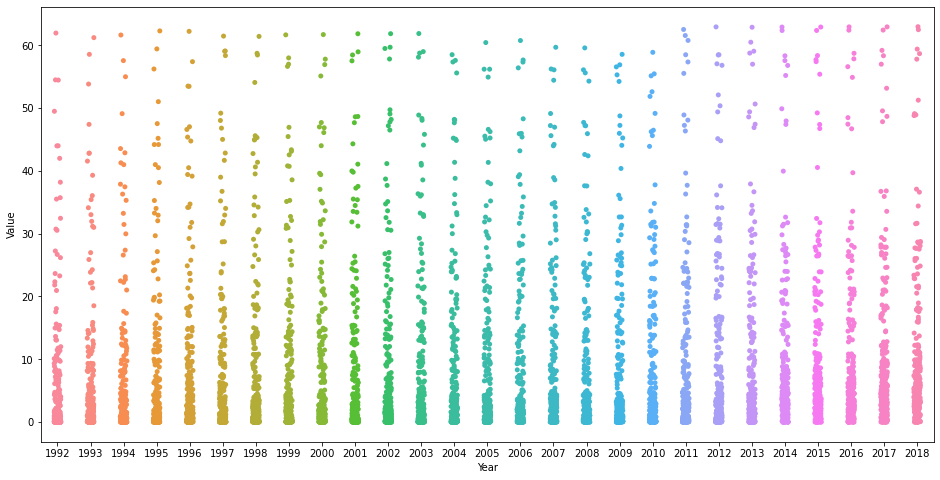

In [8]:
plt.figure(figsize=(16, 8))
sns.stripplot(x="Year", y="Value", data=nightLightCSV[nightLightCSV.Quantity == "mean"].set_index(["Year", "Quantity"]).stack().reset_index().rename(columns={"level_2":"Country", 0: "Value"}))

In [11]:
nightLightCSV

,Year,Quantity,Aruba,Afghanistan,Angola,Anguilla,Albania,Aland,Andorra,United Arab Emirates,...,U.S. Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Akrotiri Sovereign Base Area,Samoa,Yemen,South Africa,Zambia,Zimbabwe
0,1992,min,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,1992,max,63.000000,59.000000,6.300000e+01,21.000000,39.000000,53.000000,63.000000,63.000000,...,63.000000,63.000000,33.000000,5.000000,39.000000,25.000000,63.000000,6.300000e+01,63.000000,63.000000
2,1992,mean,30.731343,0.027943,3.853196e-02,9.650000,0.264269,2.225571,15.614627,5.759838,...,32.455814,0.428158,0.148032,0.614458,14.912409,0.213944,0.290173,1.011056e+00,0.086135,0.237517
3,1992,count,201.000000,901332.000000,1.491515e+06,100.000000,43766.000000,2190.000000,711.000000,90768.000000,...,430.000000,402417.000000,14990.000000,166.000000,137.000000,3342.000000,550751.000000,1.628866e+06,904610.000000,481200.000000
4,1992,std,18.759739,0.777678,9.276639e-01,4.665565,1.677334,7.450677,14.907233,12.631190,...,21.645917,2.280519,1.422269,1.511652,6.933968,1.448707,2.234735,5.345446e+00,1.452076,2.465630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2018,mean,37.089552,2.047282,1.631923e+00,15.900000,8.770347,4.557534,24.846695,17.602481,...,25.711628,8.588959,1.618412,5.855422,34.408759,3.311191,1.301654,4.085443e+00,3.077475,2.009717
185,2018,count,201.000000,901332.000000,1.491515e+06,100.000000,43766.000000,2190.000000,711.000000,90768.000000,...,430.000000,402417.000000,14990.000000,166.000000,137.000000,3342.000000,550751.000000,1.628866e+06,904610.000000,481200.000000
186,2018,std,16.243543,3.555359,3.834231e+00,7.139328,7.885158,10.894895,17.029646,19.567906,...,17.255551,10.506223,6.371589,1.767392,14.801142,3.743191,4.136651,7.545370e+00,4.123423,3.633314
187,2018,median,40.000000,0.000000,0.000000e+00,14.000000,7.000000,0.000000,19.000000,8.000000,...,20.500000,7.000000,0.000000,6.000000,34.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [14]:
df = nightLightCSV.set_index(["Year", "Quantity"]).T.sort_values((2018, "mean"), ascending=False).iloc[:5].T.stack().reset_index().set_index(["Quantity", "Year"]).loc[["mean", "min", "max", "median", "mode"]].reset_index().rename(columns={"level_2":"Country", 0: "Value"})
df

,Quantity,Year,Country,Value
0,mean,1992,Macao,49.500000
1,mean,1992,Singapore,61.957983
2,mean,1992,Monaco,54.466667
3,mean,1992,Bahrain,42.001305
4,mean,1992,Gibraltar,38.200000
...,...,...,...,...
670,mode,2018,Macao,63.000000
671,mode,2018,Singapore,63.000000
672,mode,2018,Monaco,63.000000
673,mode,2018,Bahrain,63.000000


In [15]:
df[(df.Quantity == "min") & (df.Country == "Singapore")].corr()

,Year,Value
Year,1.000000,0.503693
Value,0.503693,1.000000


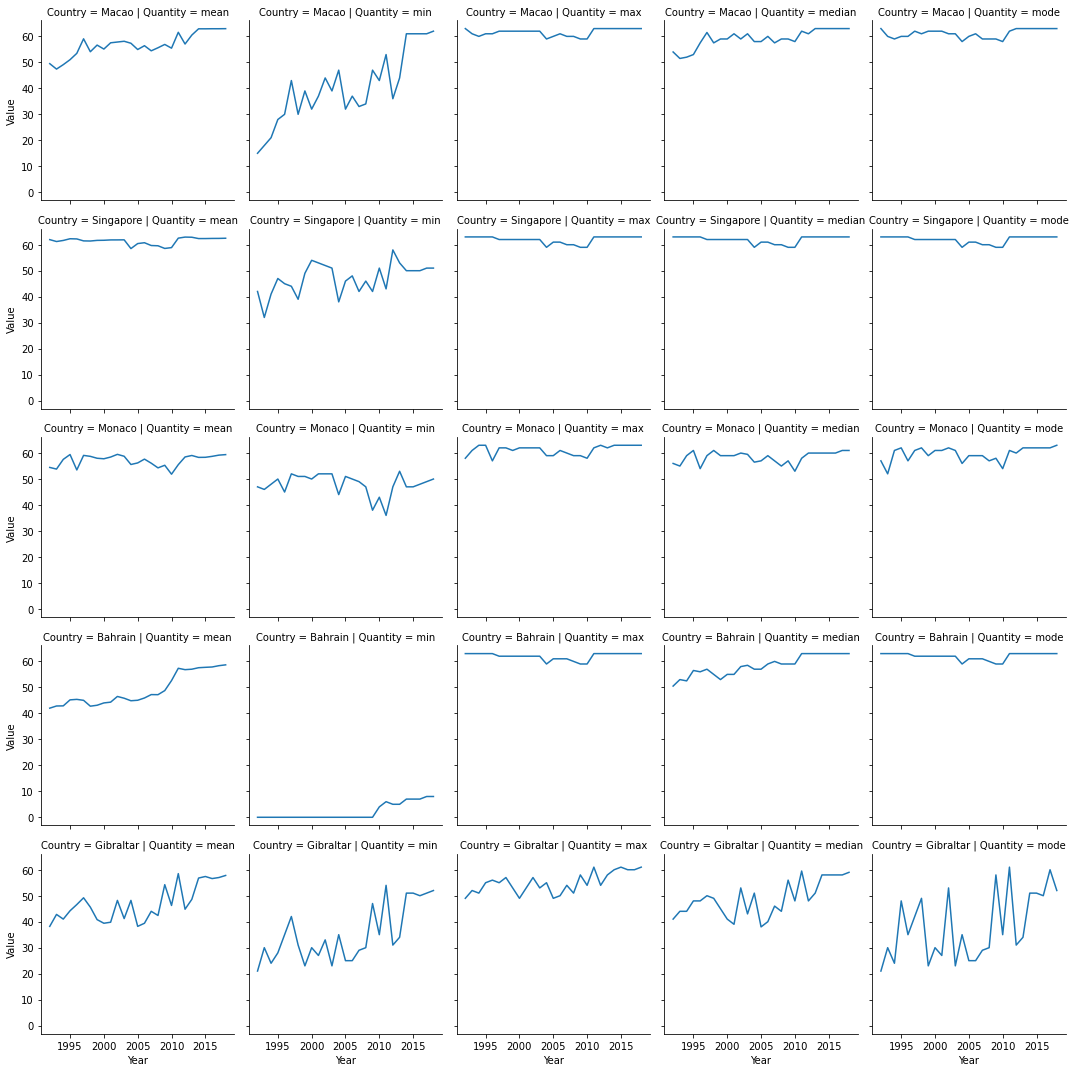

In [16]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.lineplot, "Year", "Value")

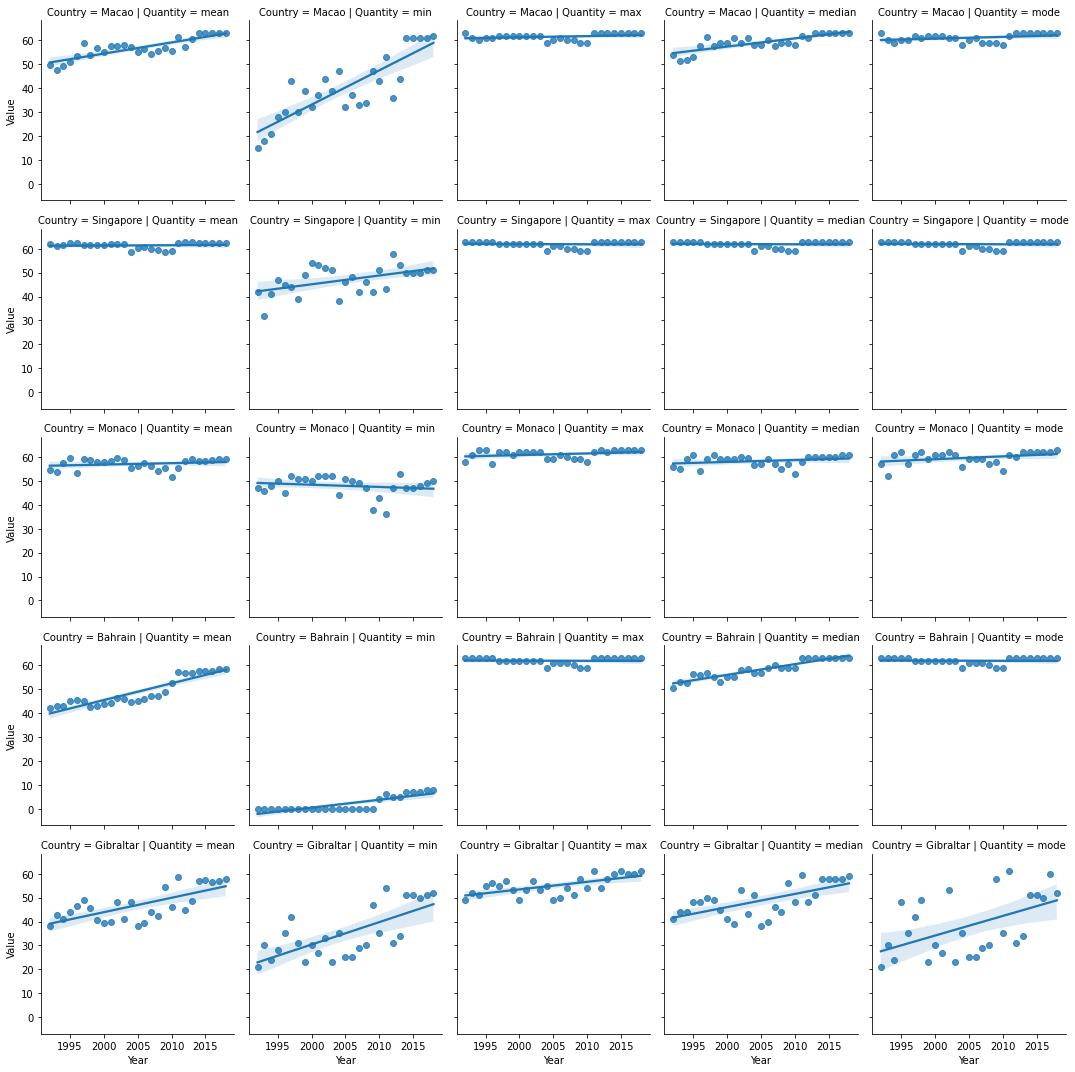

In [17]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.regplot, "Year", "Value")

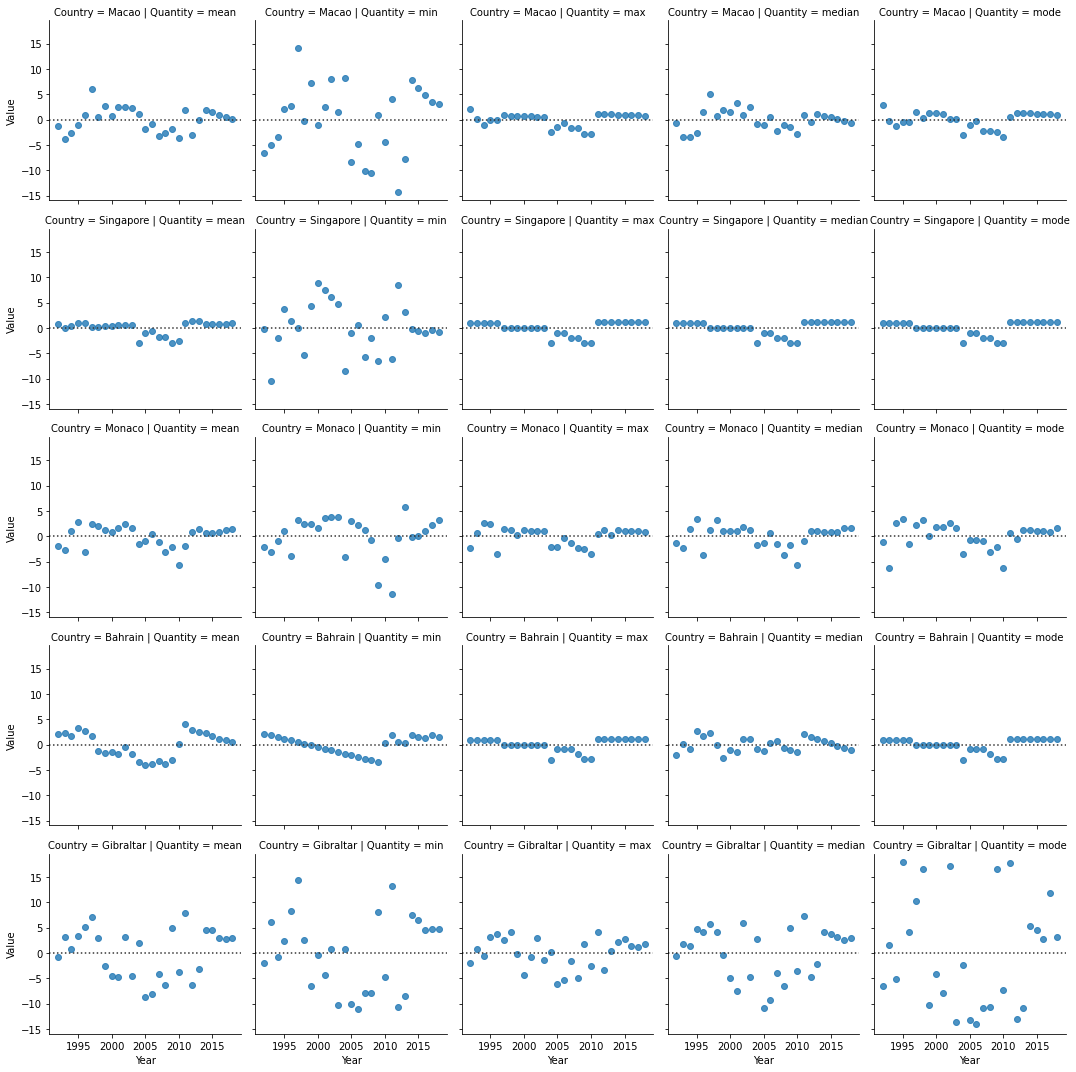

In [18]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.residplot, "Year", "Value")

<AxesSubplot:xlabel='Year,Quantity'>

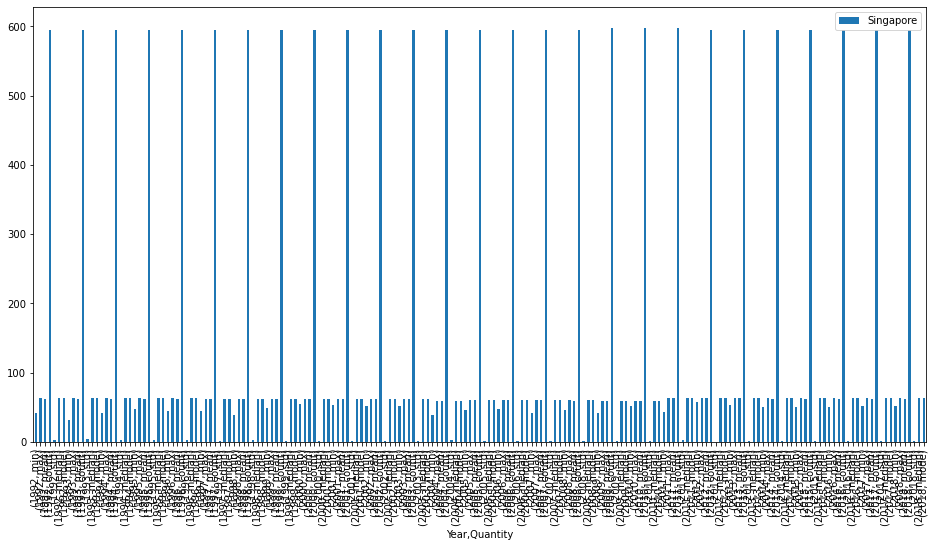

In [19]:
nightLightCSV.set_index(["Year", "Quantity"])[["Singapore"]].plot.bar(figsize=(16, 8))

<AxesSubplot:xlabel='Year'>

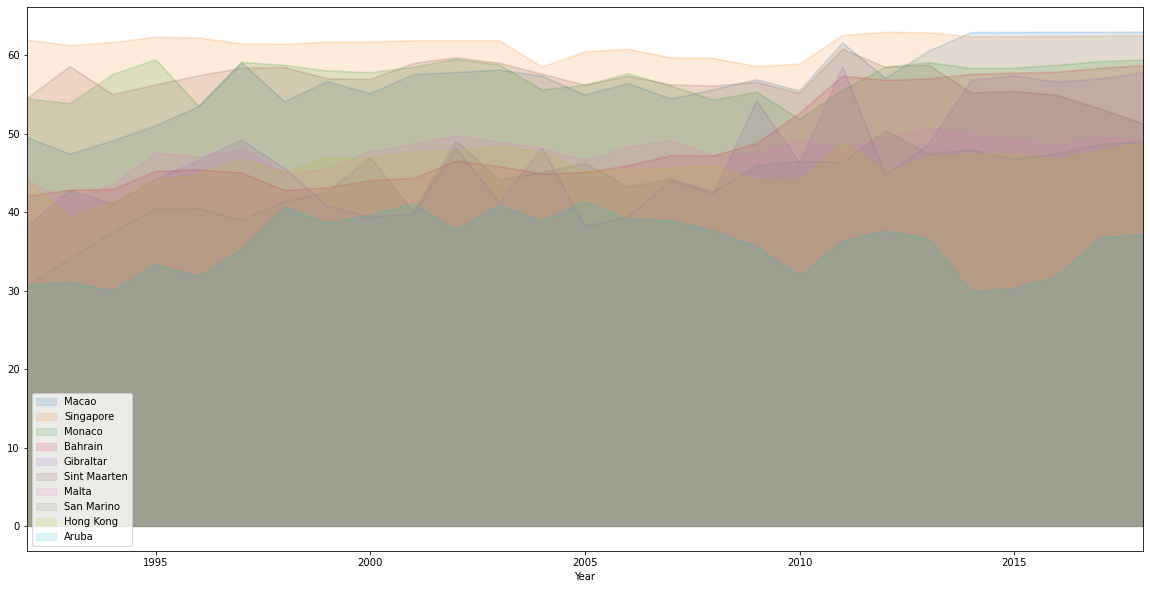

In [27]:
nightLightCSV.set_index(["Quantity", "Year"]).loc["mean"].T.sort_values(2018, ascending=False).iloc[:10].T.plot.area(figsize=(20, 10), alpha=0.15, stacked=False, xlim=[1992, 2018]) #.apply(lambda col: col.unstack()[["average", "median", "max", "min", "mode"]].plot.bar(figsize=(16, 8)))

In [46]:

nightLightCSV.set_index(["Quantity", "Year"]).T.sort_values(("mean", 2018), ascending=False).iloc[:9].T.loc[["mean", "median", "mode"]].T.stack().stack().reset_index().rename(columns={"level_0":"Country", 0:"Value"}).pivot("Year", ["Country", "Quantity"], "Value") #.plot(subplots=True, sharey=True, sharex=False, figsize=(20, 90))  #.apply(lambda country: country.unstack().T.plot(figsize=(20, 10), title="Bar Plot of Data from {}".format(country.name)))

Country       Macao               Singapore                  Monaco         \
Quantity       mean median  mode       mean median  mode       mean median   
Year                                                                         
1992      49.500000   54.0  63.0  61.957983   63.0  63.0  54.466667   56.0   
1993      47.411765   51.5  60.0  61.228571   63.0  63.0  53.833333   55.0   
1994      49.117647   52.0  59.0  61.643697   63.0  63.0  57.566667   59.0   
1995      51.029412   53.0  60.0  62.297479   63.0  63.0  59.433333   61.0   
1996      53.470588   57.5  60.0  62.228571   63.0  63.0  53.500000   54.0   
1997      59.058824   61.5  62.0  61.470588   62.0  62.0  59.100000   59.0   
1998      54.088235   57.5  61.0  61.425210   62.0  62.0  58.733333   61.0   
1999      56.647059   59.0  62.0  61.668908   62.0  62.0  58.000000   59.0   
2000      55.117647   59.0  62.0  61.712605   62.0  62.0  57.800000   59.0   
2001      57.529412   61.0  62.0  61.845378   62.0  62.0  58.466667   59.0   
2002      57.823529   59.0  61.0  61.855462   62.0  62.0  59.500000   60.0   
2003      58.117647   61.0  61.0  61.878992   62.0  62.0  58.766667   59.5   
2004      57.352941   58.0  58.0  58.512605   59.0  59.0  55.600000   56.5   
2005      54.941176   58.0  60.0  60.442017   61.0  61.0  56.200000   57.0   
2006      56.411765   60.0  61.0  60.766387   61.0  61.0  57.666667   59.0   
2007      54.441176   57.5  59.0  59.692437   60.0  60.0  56.100000   57.0   
2008      55.617647   59.0  59.0  59.593277   60.0  60.0  54.300000   55.0   
2009      56.897436   59.0  59.0  58.565217   59.0  59.0  55.300000   57.0   
2010      55.461538   58.0  58.0  58.886288   59.0  59.0  51.866667   53.0   
2011      61.564103   62.0  62.0  62.528428   63.0  63.0  55.533333   58.0   
2012      57.058824   61.0  63.0  62.937815   63.0  63.0  58.500000   60.0   
2013      60.500000   63.0  63.0  62.880672   63.0  63.0  59.066667   60.0   
2014      62.911765   63.0  63.0  62.366387   63.0  63.0  58.333333   60.0   
2015      62.911765   63.0  63.0  62.371429   63.0  63.0  58.366667   60.0   
2016      62.941176   63.0  63.0  62.416807   63.0  63.0  58.733333   60.0   
2017      62.941176   63.0  63.0  62.430252   63.0  63.0  59.200000   61.0   
2018      62.970588   63.0  63.0  62.495798   63.0  63.0  59.400000   61.0   

Country           Bahrain  ... Sint Maarten      Malta               \
Quantity  mode       mean  ...         mode       mean median  mode   
Year                       ...                                        
1992      57.0  42.001305  ...         62.0  43.985011   47.0  63.0   
1993      52.0  42.835509  ...         62.0  41.561028   44.0  61.0   
1994      61.0  42.883812  ...         60.0  43.554604   46.0  63.0   
1995      62.0  45.193211  ...         61.0  47.531049   53.0  63.0   
1996      57.0  45.382507  ...         62.0  47.032120   53.0  62.0   
1997      61.0  45.016971  ...         62.0  48.032120   53.0  62.0   
1998      62.0  42.761097  ...         62.0  44.929336   49.0  62.0   
1999      59.0  43.122715  ...         61.0  45.471092   50.0  61.0   
2000      61.0  44.013055  ...         62.0  47.702355   52.0  62.0   
2001      61.0  44.310705  ...         62.0  48.668094   54.0  62.0   
2002      62.0  46.505222  ...         62.0  49.732334   55.0  62.0   
2003      61.0  45.825065  ...         62.0  48.892934   55.0  62.0   
2004      56.0  44.855091  ...         59.0  48.113490   53.0  59.0   
2005      59.0  45.043081  ...         59.0  46.612420   51.0  59.0   
2006      59.0  45.916449  ...         61.0  48.297645   53.0  61.0   
2007      59.0  47.220627  ...         59.0  49.139186   56.0  60.0   
2008      57.0  47.189295  ...         59.0  47.226981   54.0  59.0   
2009      58.0  48.760582  ...         58.0  47.249471   51.0  59.0   
2010      54.0  52.612434  ...         58.0  49.160677   54.0  59.0   
2011      61.0  57.351852  ...         62.0  48.090909   55.0  63.0   
2012      60.0  56.818538 

In [ ]:
nightLightNoDark = functools.reduce(pd.merge, map(lambda x: retrieveGeoStats(x, 0), glob("data/nightLight/Harmonized*.tif")))
nightLightNoDark

In [ ]:
df = pd.DataFrame(nightLightNoDark.drop(columns=["bbox", "ISO_A3", "geometry"]).set_index("Country").rename(columns = lambda name : tuple(name.split("LightPollution")[::-1]) if "LightPollution" in name else (name[-4:], "count")).T.reset_index(drop=False))
df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
df = df.drop(columns=["index"]).set_index(["Year", "Quantity"]).fillna(0)
df.to_csv("data/nightLight/nightLightNoDark.csv")
nightLightCSVNoDark = pd.read_csv("data/nightLight/nightLightNoDark.csv")
nightLightCSVNoDark